In [1]:
#%load_ext signature
%matplotlib inline
import os

import requests
import io

import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

# World map shape by http://www.naturalearthdata.com/downloads/10m-cultural-vectors/
shapefile = os.path.expanduser('Resources/ne_10m_admin_0_countries_lakes/ne_10m_admin_0_countries_lakes.shp')

colors = 9
cmap = 'Greens'
figsize = (16, 10)
year = '2016'
cols = ['Country Name', 'Country Code', year]
title = 'Grazing land usage by percentage in {}'.format(year)
imgfile = 'img/{}.png'.format(title)

description = '''
Global hectares of grazing land (used for meat, dairy, leather, etc.) available or demanded. 
Includes global hectares used for grazing, but not crop land used to produce feed for animals.'''

### Load Choropleth Map Shape DataFrame

In [2]:
gdf = gpd.read_file(shapefile)[['ADM0_A3', 'geometry']].to_crs('+proj=robin')

### Load Grazing Land DataFrame

In [3]:
# Set FAO stardand url parametrs
fao_area_cs = '&area_cs=FAO'
fao_item_cs = '&item_cs=FAO'
fao_tail = '&show_codes=true&show_unit=true&show_flags=true&null_values=false&output_type=csv'

# Agri-environmental Indicators: Land Use -> 2016 Grazing Land Value %
# Set url parametrs
fao_base_url = 'http://fenixservices.fao.org/faostat/api/v1/en/data/EL?'
area_str = '5000%3E%2C351' # 5000%3E represents the list of all countries + the missing China from list
fao_area = 'area=' + area_str
fao_year = '&year=' + str(year)
element_str = '7209' # Share in Land area
fao_element = '&element=' + element_str
item_str = '6655' # Land under perm. meadows and pastures
fao_item = '&item=' + item_str
# finalize fao url
gl_fao_url = fao_base_url + fao_area + fao_area_cs + fao_element + fao_item  + fao_item_cs + fao_year + fao_tail

# Request Get Agri-environmental Indicators: Land Use from FOA
response = requests.get(gl_fao_url)
decoded_content = response.content.decode('ISO-8859-1')
# Store CSV to DataFrame
fao_gl_df = pd.read_csv(io.BytesIO(response.content), encoding='ISO-8859-1')
fao_gl_df = fao_gl_df[['Area Code', 'Area', 'Year', 'Value', 'Unit']]
fao_gl_df.head()

,Area Code,Area,Year,Value,Unit
0,2,Afghanistan,2016,45.95,%
1,3,Albania,2016,17.45,%
2,4,Algeria,2016,13.83,%
3,6,Andorra,2016,38.30,%
4,7,Angola,2016,43.31,%


In [4]:
# Load GFN country code
gfn_csv_path = "Resources/Country/GFN Country code concordance table.csv"
gfn_df = pd.read_csv(gfn_csv_path)
# Merge GFN ISO Alpha-3 Code to fao_gl_df
map_df = pd.merge(fao_gl_df, gfn_df, how='left', left_on='Area Code', right_on='GFN Country Code')
map_df.head()

,Area Code,Area,Year,Value,Unit,Country Name,GFN Country Code,ISO Alpha-2 Code,ISO Alpha-3 Code
0,2,Afghanistan,2016,45.95,%,Afghanistan,2,AF,AFG
1,3,Albania,2016,17.45,%,Albania,3,AL,ALB
2,4,Algeria,2016,13.83,%,Algeria,4,DZ,DZA
3,6,Andorra,2016,38.30,%,Andorra,6,AD,AND
4,7,Angola,2016,43.31,%,Angola,7,AO,AGO


### Merge World map shape with Graze Land DataFrame by country code

In [5]:
merged = gdf.merge(map_df, how='left', left_on='ADM0_A3', right_on='ISO Alpha-3 Code')
merged.head()

,ADM0_A3,geometry,Area Code,Area,Year,Value,Unit,Country Name,GFN Country Code,ISO Alpha-2 Code,ISO Alpha-3 Code
0,IDN,(POLYGON ((11108970.26020776 445285.1302330397...,101.0,Indonesia,2016.0,6.07,%,Indonesia,101.0,ID,IDN
1,MYS,(POLYGON ((11108970.26020776 445285.1302330397...,131.0,Malaysia,2016.0,0.87,%,Malaysia,131.0,MY,MYS
2,CHL,(POLYGON ((-6477059.899247097 -1872360.8384665...,40.0,Chile,2016.0,18.85,%,Chile,40.0,CL,CHL
3,BOL,POLYGON ((-6477059.899247097 -1872360.83846657...,19.0,Bolivia (Plurinational State of),2016.0,30.46,%,Bolivia,19.0,BO,BOL
4,PER,(POLYGON ((-6477059.899247097 -1872360.8384665...,170.0,Peru,2016.0,14.69,%,Peru,170.0,PE,PER


### Plot Choropleth World Map

/anaconda3/envs/GeoEnv/lib/python3.6/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)


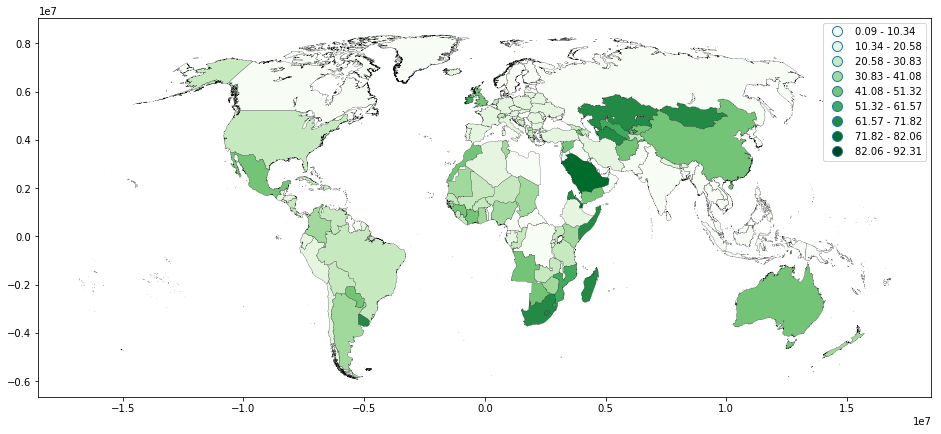

In [6]:
ax = merged.dropna().plot(column='Value', cmap=cmap, figsize=figsize, scheme='equal_interval', k=colors, legend=True, edgecolors='black', linewidth=0.2)


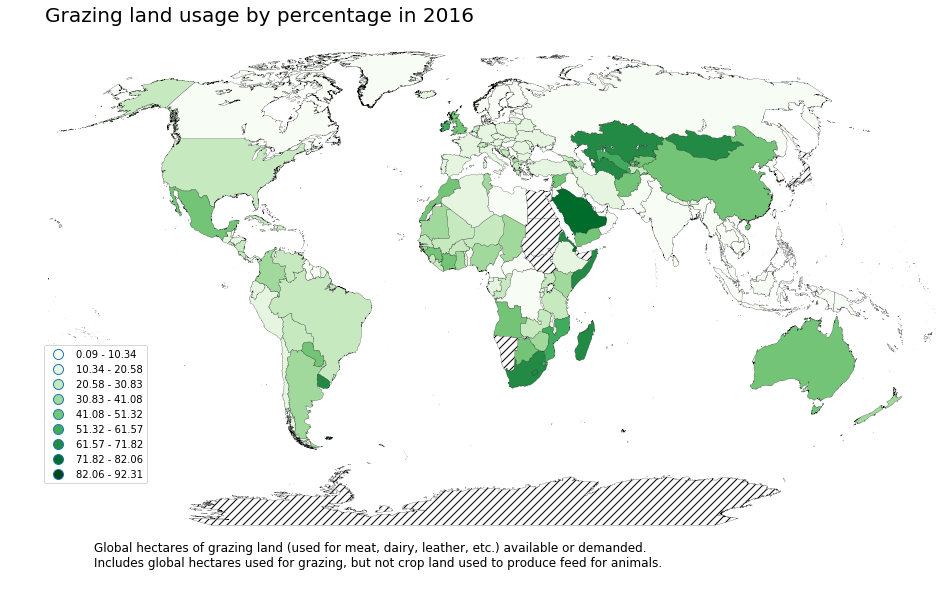

<Figure size 432x288 with 0 Axes>

In [7]:
# Set null countries to white with hack='///'
merged[merged.isna().any(axis=1)].plot(ax=ax, color='#fafafa', hatch='///', edgecolors='black', linewidth=0.2)

# Set map settings
ax.set_title(title, fontdict={'fontsize': 20}, loc='left')
ax.annotate(description, xy=(0.1, 0.07), size=12, xycoords='figure fraction')

ax.set_axis_off()
ax.set_xlim([-1.5e7, 1.7e7])
ax.get_legend().set_bbox_to_anchor((.12, .4))
# Save Map Plot
fig = ax.get_figure()
fig.savefig(imgfile, bbox_inches='tight', pad_inches=.2)
# Display Map Plot
ax.get_figure()